# House Pricing Revised

## HELP NEEDED: Transforming Target Does not Help Much 

# Set Up

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_rows', 81)
pd.set_option('display.max_columns', 300)

In [34]:
df_train = pd.read_csv("/Users/drewpeterson/Documents/Programming/Python/DataSets/Kaggle/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/Users/drewpeterson/Documents/Programming/Python/DataSets/Kaggle/house-prices-advanced-regression-techniques/test.csv")

df_train.drop(df_train[df_train.Utilities == "NoSeWa"].index, inplace=True)
df_train = df_train[df_train.Electrical.isnull() == False]
df_train.loc[(df_train.MasVnrType.isnull()) & (df_train.MasVnrArea > 0.0), "MasVnrType"] = df_train.MasVnrType.mode()[0]
df_train.drop(df_train[df_train.GrLivArea > 4500].index, inplace = True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns="SalePrice"), df_train[["SalePrice"]], test_size=0.2, random_state=0)

Transform y_train

In [36]:
y_train_transformed = pd.DataFrame(np.log1p(y_train))

## Built Functions

In [37]:
# No Effect on Data

def see_null(df_example):
    null_list = []
    null_df = df_example.isnull().sum().reset_index()
    null_df = null_df[null_df[0]>0]
    return null_df


def full_test(df_example, y_example):

    df_example = df_example.copy()

    example_clean = clean_data1(df_example)

    example_clean_engineered = feature_engineering(example_clean)

    example_clean_engineered_encoded = encode_data(example_clean_engineered)

    rmse = root_mean_squared_error(lasso_model.predict(example_clean_engineered_encoded), y_example)

    return rmse

In [21]:
linear_df = X_train[X_train.LotFrontage.isnull()==False]
linear = LinearRegression()
model = linear.fit(linear_df[["LotArea"]], linear_df[["LotFrontage"]])
model.predict(pd.DataFrame([8246], columns = ["LotArea"] ))[0][0]

67.47673982862078

# Data Cleaning

In [38]:
def clean_data1(df_example):
    """This Function is the first step to Data Cleaning
        CATEGORICAL
        Replaces Null in Categorical Columns with Category titled FEATURE_NOT_PRESENT
        Replaces Null of One-Offs with Mode of Column (assume missing at Random)
        
        NUMERICAL
        Replace Null with 0 where applicable
        Interpolates LotFrontage based on Lot Area
        Imputes One-Off Nulls with Median of Column in X_train
        """
    
    df_example = df_example.copy()

    # Categorical Columns, Fill NA as Separate Category
    for each_column in df_example.select_dtypes(include="object").columns:
        # Check if there are One-Off Nulls (under 5 null Values, wouldnt make sense to be its own category, assume missing at random), impute the median of the column from X_train 
        # Else, create separate category if strutrure not present
        if df_example[each_column].isnull().sum() < 5:
            df_example[each_column].fillna(X_train[each_column].mode()[0])
        else:
            df_example[each_column] = df_example[each_column].fillna("FEATURE_NOT_PRESENT")
            


    # Numercial Columns
    df_example['GarageYrBlt'] = df_example['GarageYrBlt'].fillna(0)

    # For df_train, able to further manipulate MasVnrArea, if there is an area, but the type is null, then impute the MasVnrType with X_train.MasVnrType.mode()[0]
    df_example['MasVnrArea'] = df_example['MasVnrArea'].fillna(0)

    # For LotFrontage, it doesnt make sense for the value to be 0. Check if there is a connection with other numeric feautre, then linear interpolate that
    df_example["LotFrontage"] = df_example.apply(lambda x: x.LotFrontage if x.LotFrontage > 1 else model.predict(pd.DataFrame([x.LotArea], columns = ["LotArea"]) )[0][0], axis =1)

    # Impute One-Off Numerical Nulls with Median of X_train
    for each_column in df_example.select_dtypes(exclude="object").columns:
        if df_example[each_column].isnull().sum() < 5:
            df_example[each_column].fillna(X_train[each_column].median())

    return df_example

X_clean = clean_data1(X_train)

# Feature Engineering

In [39]:
def feature_engineering(df_example):
    
    df_example = df_example.copy()
    
    today = dt.today()

    # Converting Home Age & Remodel 
    df_example["HomeAge"] = today.year - df_example.YearBuilt
    df_example["SinceRemodel"] = today.year - df_example.YearRemodAdd

    # Converting Sale Date to Days Since Sold
    df_example["SaleDate"] = df_example.apply(lambda x: dt(x.YrSold, x.MoSold, 1), axis =1)
    df_example["TimeSinceSold"] = today - df_example.SaleDate
    df_example["DaysSinceSold"] = df_example.TimeSinceSold.apply(lambda x: x.days)

    # Converting Garage Age
    df_example["GarageAge"] = today.year - df_example.GarageYrBlt
    df_example.GarageAge = df_example.GarageAge.apply(lambda x: 0 if x > 1000 else x)

    # Converting Pool to Binary
    df_example["Pool"] = df_example.PoolArea.apply(lambda x: 1 if x > 100 else 0)

    df_example.drop(columns = ["Utilities", "Id", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold", "SaleDate","TimeSinceSold", "GarageYrBlt",  "PoolArea", "PoolQC"], inplace=True)

    return df_example

X_clean_engineered = feature_engineering(X_clean)

# Encode Data

In [40]:
inst = ce.OneHotEncoder()
cat_cols = X_clean_engineered.select_dtypes(include="object").columns
num_cols = X_clean_engineered.select_dtypes(exclude="object").columns
inst.fit(X_clean_engineered[cat_cols], columns = cat_cols)

def encode_data(df_example):
    
    df_example = df_example.copy()
    
    # Encode Categorical
    df_example = df_example.drop(columns = cat_cols).join(inst.transform(df_example[cat_cols]))

    # Transform Numerical
    #df_example[num_cols] = np.log1p(df_example[num_cols])

    return df_example

X_clean_engineered_encoded = encode_data(X_clean_engineered)
    

# Lasso Model

Alpha of 200 or 220

In [47]:
las = Lasso(alpha=200)
lasso_model = las.fit(X_clean_engineered_encoded,y_train)

In [48]:
lasso_model.predict(X_clean_engineered_encoded)

array([249738.51111371, 205210.38483875, 108711.22972854, ...,
        79900.64750508, 157311.64417969, 232190.16037595])

In [49]:
root_mean_squared_error(lasso_model.predict(X_clean_engineered_encoded),y_train)

22308.415454960534

In [44]:
root_mean_squared_error(np.expm1(lasso_model.predict(X_clean_engineered_encoded)),np.expm1(y_train_transformed))

79077.20105747097

In [12]:
# Cleaning, Feature Engineering, and Encoding for X_test 
X_test_clean = clean_data1(X_test)
X_test_clean_eng = feature_engineering(X_test_clean)
X_test_clean_eng_enc = encode_data(X_test_clean_eng)
X_test_preds = lasso_model.predict(X_test_clean_eng_enc)

In [13]:
root_mean_squared_error(np.expm1(X_test_preds),y_test)

85040.21249836468

Transforming the Y_train data with np.log1p results in entry RMSE of 0.40

Transforming all Numerical Data in X_train, and transforming y_train results in entry RMSE of 0.42

# Entry Predictions

In [14]:
test_clean = clean_data1(df_test)

test_clean_engineered = feature_engineering(test_clean)

test_clean_engineered_encoded = encode_data(test_clean_engineered)

null_cols = list(see_null(test_clean_engineered_encoded)["index"])
for each in null_cols:
    test_clean_engineered_encoded[each] = test_clean_engineered_encoded[each].fillna(X_clean_engineered_encoded[each].median())

np.expm1(lasso_model.predict(test_clean_engineered_encoded))



df_entry = pd.DataFrame([])
df_entry["Id"] = df_test.Id
df_entry["SalePrice"] = np.expm1(lasso_model.predict(test_clean_engineered_encoded))
df_entry.to_csv("20th_entry.csv", index = False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


# Plotting Relationship with Each Feature and Y

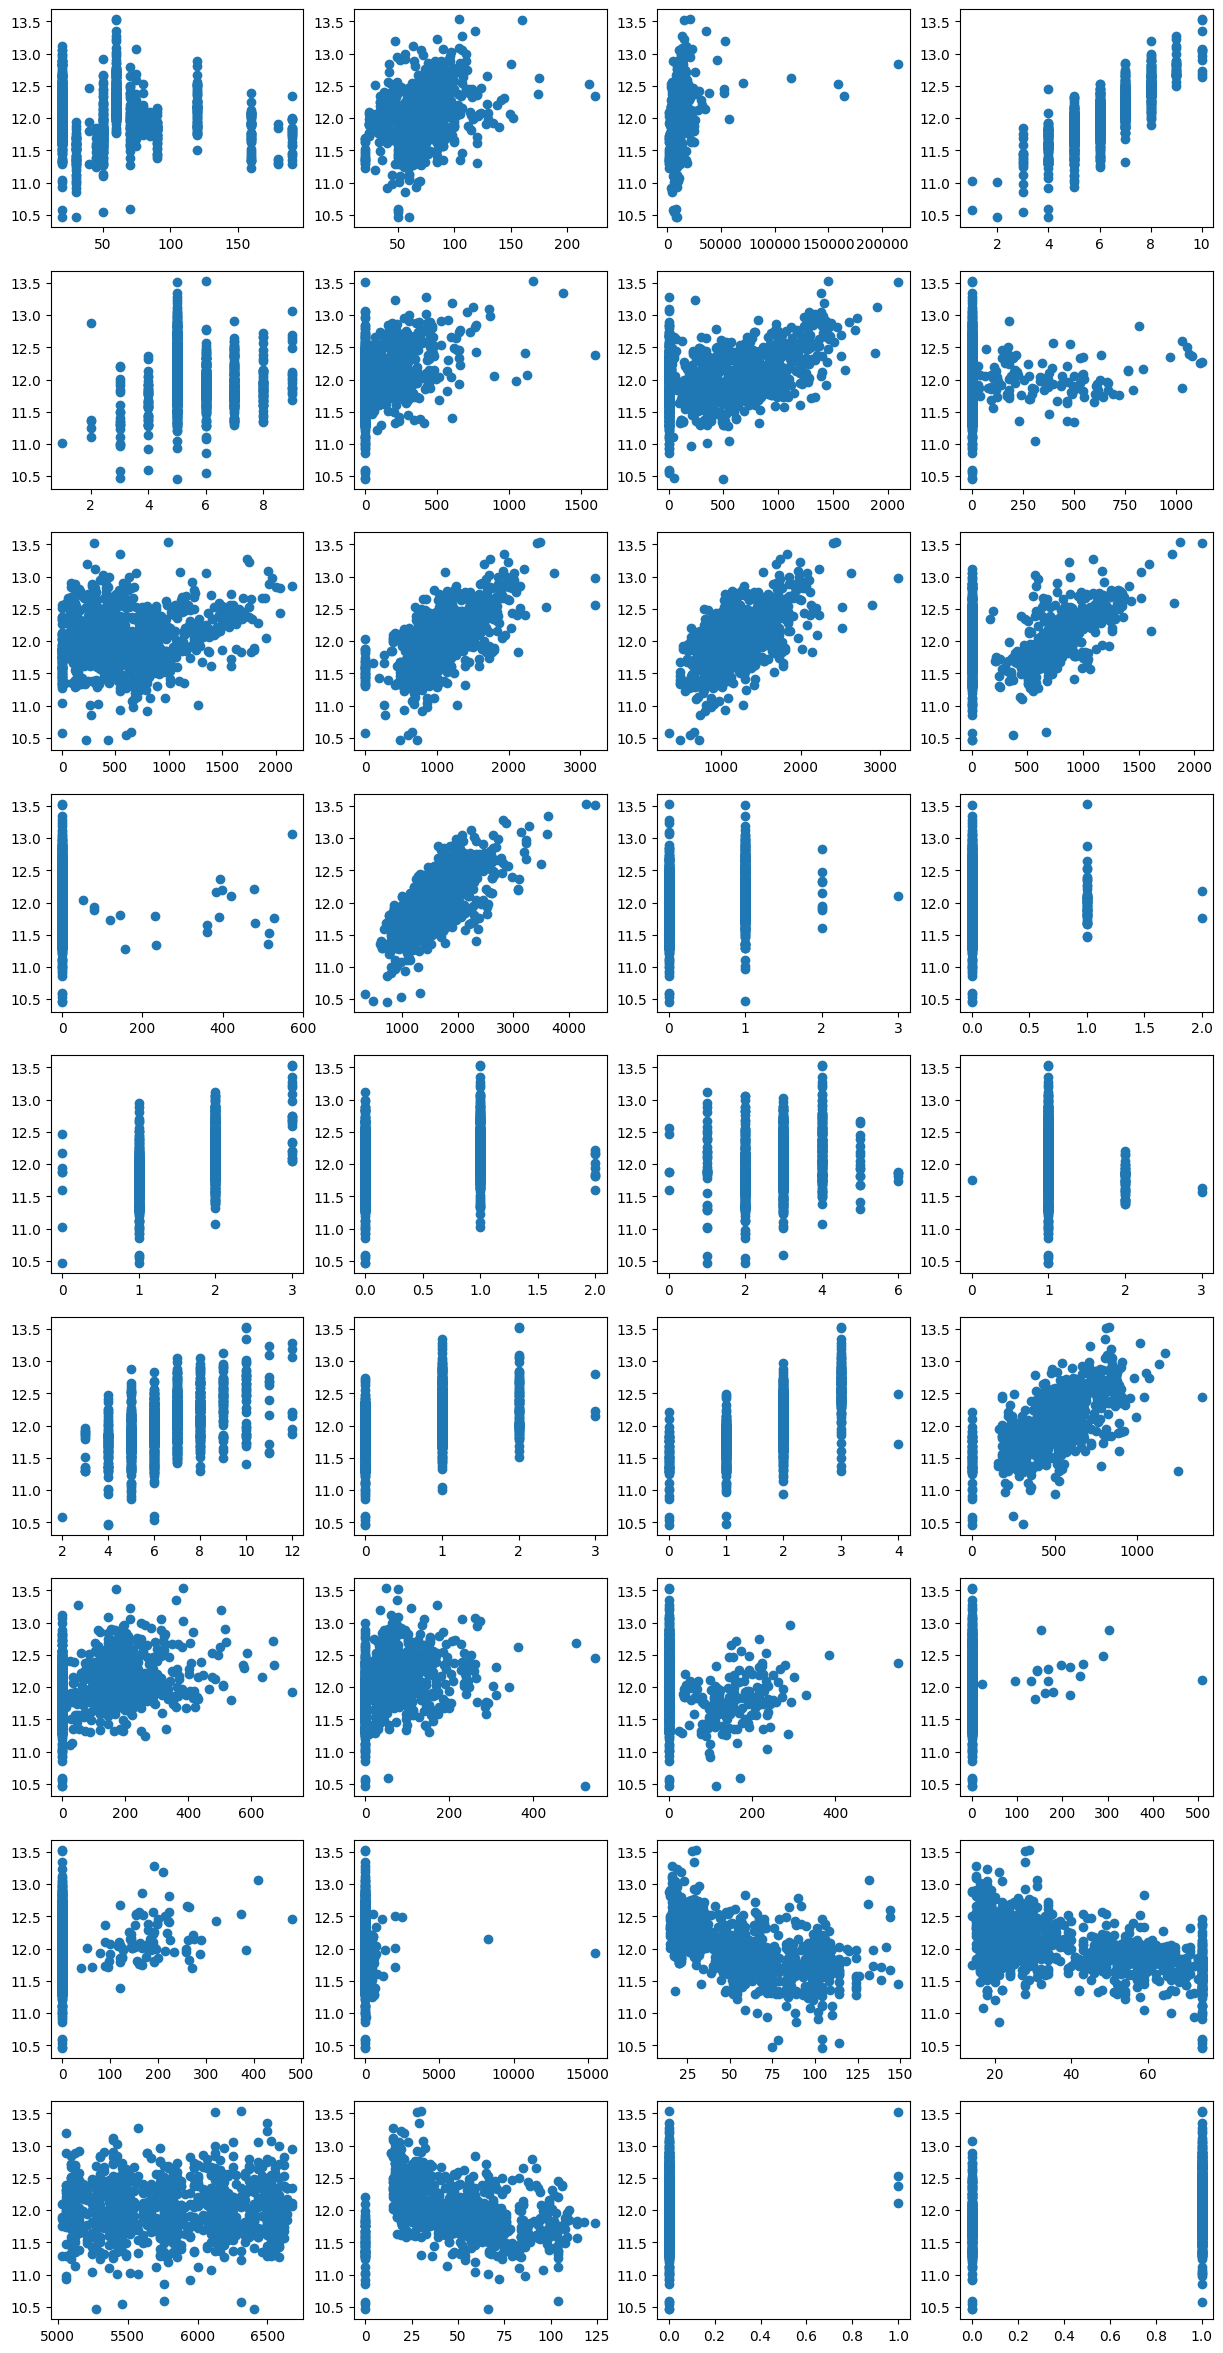

In [53]:
fig, ax = plt.subplots(9, 4, figsize=(15, 6*5)) 
for i in range(9):
    for j in range(4):
        ax[i,j].scatter(X_clean_engineered_encoded.iloc[:, i*4 + j], y_train_transformed)